<a href="https://colab.research.google.com/github/ChallapalliHemanthsaikumar/time_series_2024_of_BTC/blob/main/BTC_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Writing a Function that downloads Data Until Yesterday Date


In [3]:
import datetime

def date_return():
  today = datetime.date.today()
  years_ago =  today - datetime.timedelta(days= 14 * 365)
  return years_ago,today

def data_download(ticker,start,end):
  data = yf.download(ticker,start,end)
  return data

####   Downloading the data

ticker = "BTC-USD"
start,end = date_return()
btc_data = data_download(ticker,start,end)


### Saving the Data as csv File

btc_data.to_csv('btc_data.csv')
btc_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [69]:
btc_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-06,67840.570312,69629.601562,67491.718750,68896.109375,68896.109375,19967785809
2024-04-07,68897.109375,70284.429688,68851.632812,69362.554688,69362.554688,21204930369
2024-04-08,69362.554688,72715.359375,69064.242188,71631.359375,71631.359375,37261432669
2024-04-09,71632.500000,71742.507812,68212.921875,69139.015625,69139.015625,36426900409
2024-04-10,69140.242188,71093.429688,67503.562500,70587.882812,70587.882812,38318601774


### Taking Only Close and Volume Features to Develop a Model

In [4]:
btc_data_modified = pd.DataFrame(btc_data[['Close',"Volume"]]).rename(columns={'Close': 'price',"Volume":"Volume"})
btc_data_modified.head()

,price,Volume
Date,,
2014-09-17,457.334015,21056800
2014-09-18,424.440002,34483200
2014-09-19,394.795990,37919700
2014-09-20,408.903992,36863600
2014-09-21,398.821014,26580100


### Seeing The Correlation Between price and Volume

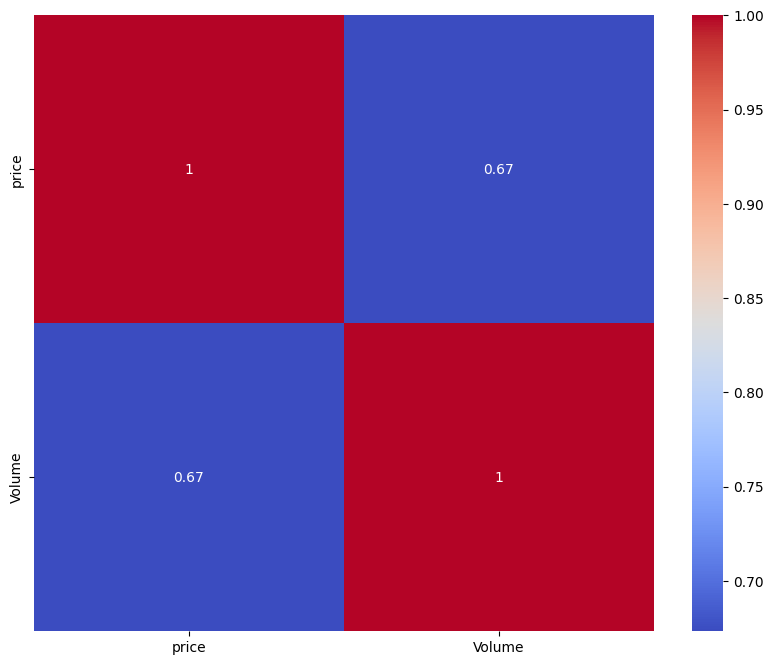

In [5]:
corr = btc_data_modified.corr()
corr
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm');

##### Now seeing the correlation Between all the values


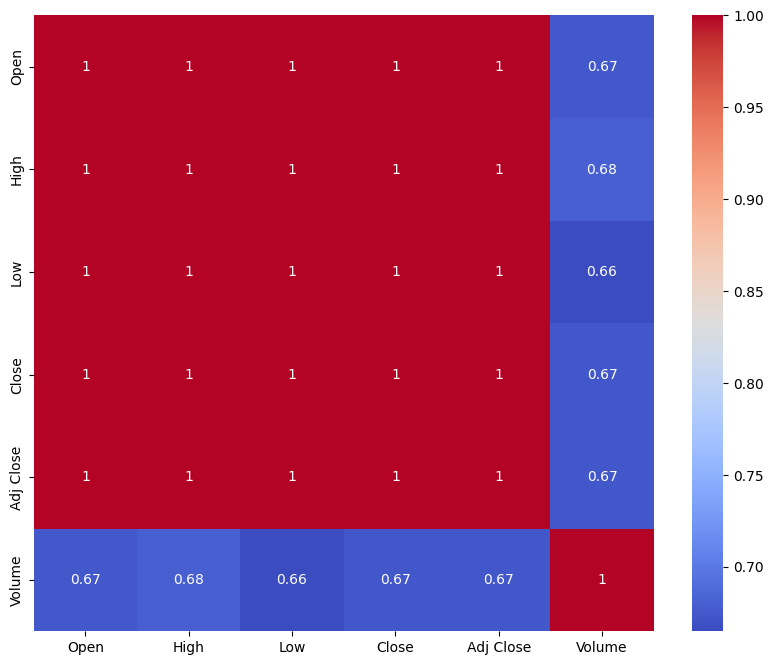

In [6]:
corr = btc_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm');

###### By visualizing the Above Figure we get know that for Open and Volume there is 0.01%  correlation more than Close and Volume

##### But as you all know that  we need to predict the Price of Bitcoin By the End of the Day so we will choose Volume and Close as our features

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [8]:
btc_data_modified.describe()

,price,Volume
count,3494.000000,3.494000e+03
mean,15753.615306,1.705644e+10
std,17446.496425,1.926863e+10
min,178.102997,5.914570e+06
25%,1004.475006,2.042098e+08
50%,8644.146484,1.272551e+10
75%,26579.523926,2.743327e+10
max,73083.500000,3.509679e+11


In [9]:
btc_data_modified.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3494 entries, 2014-09-17 to 2024-04-10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   3494 non-null   float64
 1   Volume  3494 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 81.9 KB


By seeing the Data there is no Null Values There is no need to drop values or rows

### Visualizing Bitcoin Price from 2015 to 2024

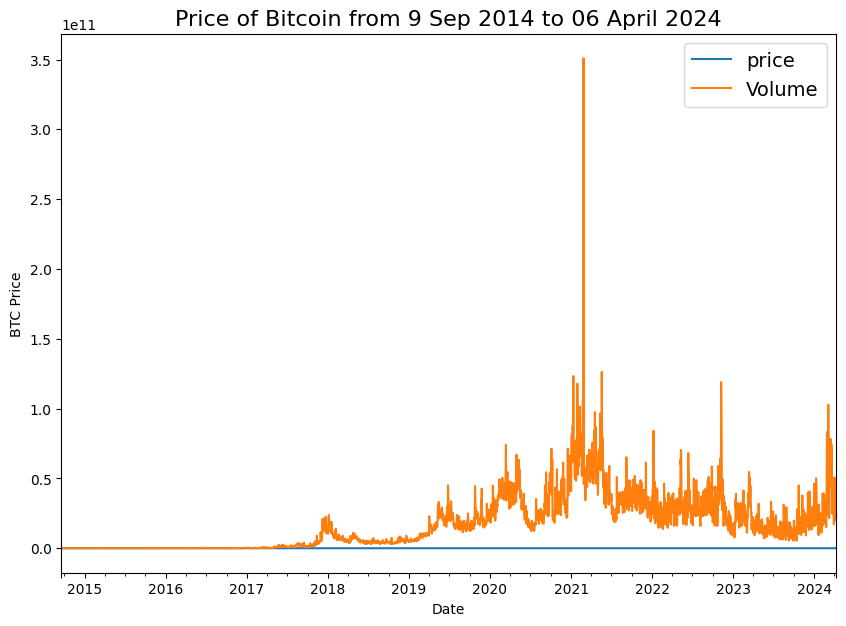

In [10]:
import matplotlib.pyplot as plt
btc_data_modified.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 9 Sep 2014 to 06 April 2024", fontsize=16)
plt.legend(fontsize=14);

##### Because of the Volume is soo Large we are Seeing the Price Column where in reality it is not Flat We need to Normalize Both Them to understand using MinMaxScaler to Understand Them Well

#### MultiVariate





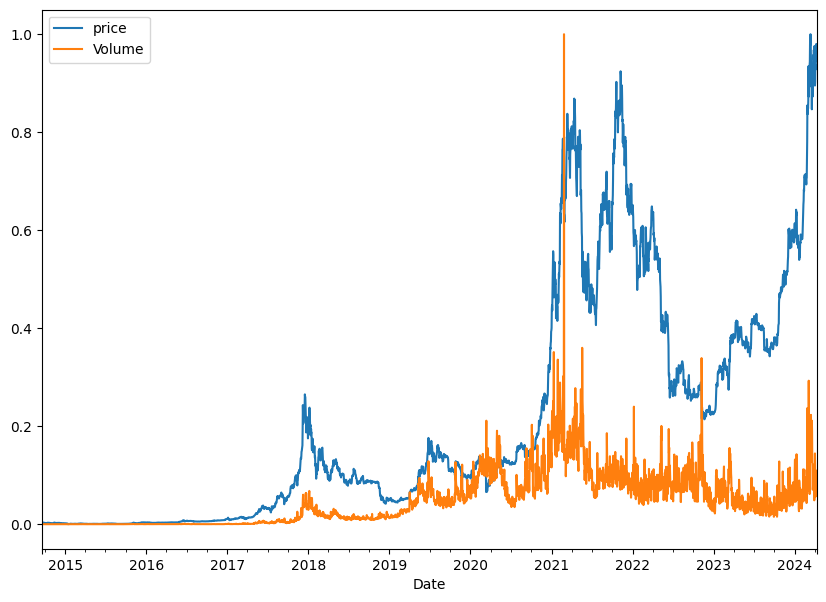

In [11]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(btc_data_modified[["price","Volume"]]), # we need to scale the data first
                                     columns=btc_data_modified.columns,
                                     index=btc_data_modified.index)
scaled_price_block_df.plot(figsize=(10, 7));


#### Visualize By Seeing The Above the Plot We Know that Whenever The Price of Bitcoin Falls The Number Of People Buying it Increases

### Building The First Model Where

#### In this Model We are Using Only Price Feature Not this Volume Feature

In [12]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [13]:
bitcoin_prices_windowed = btc_data_modified.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,price,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2014-09-17,457.334015,21056800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,34483200,457.334015,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,37919700,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,36863600,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN
2014-09-21,398.821014,26580100,408.903992,394.795990,424.440002,457.334015,NaN,NaN,NaN
2014-09-22,402.152008,24127600,398.821014,408.903992,394.795990,424.440002,457.334015,NaN,NaN
2014-09-23,435.790985,45099500,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015,NaN
2014-09-24,423.204987,30627700,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,411.574005,26814400,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002


In [14]:
### Seperating the Dataset

##### Creating X and Y Files For The Price

In [15]:
X = bitcoin_prices_windowed.dropna().drop("price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["price"].astype(np.float32)
X.head()

,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,30627700.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,26814400.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,21460800.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,15029300.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,23613300.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [16]:
y.head()

Date
2014-09-24    423.204987
2014-09-25    411.574005
2014-09-26    404.424988
2014-09-27    399.519989
2014-09-28    377.181000
Name: price, dtype: float32

In [17]:
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2789, 2789, 698, 698)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Make multivariate time series model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_1_dense_multivariate")

# Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())



In [19]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

In [20]:
history = model_1.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

## Training and Validation Loss

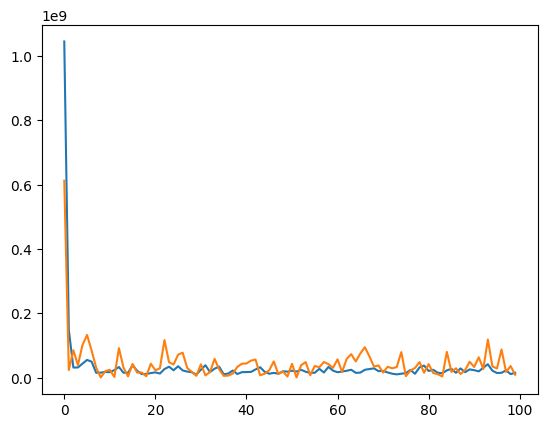

In [21]:

plt.plot(history.history['loss'])
plt.plot(history.history["val_loss"])
plt.show()


#### The Above Loss is the decreasing , our model is not training it is just predicting random numbers

In [22]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense_multivariate")
model_1.evaluate(X_test, y_test)

22/22 [==============================] - 0s 2ms/step - loss: 435108.5000


435108.5

In [23]:
# Make predictions on multivariate data
model_1_preds = tf.squeeze(model_1.predict(X_test))
model_1_preds[:10]

22/22 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-471552., -423808., -544512., -482304., -520320., -563968.,
       -511104., -274816., -351360., -525056.], dtype=float32)>

In [24]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  # mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()
          }

In [25]:
model_1_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_1_preds)
model_1_results

{'mae': 435117.03, 'mse': 247670520000.0, 'rmse': 497665.06, 'mape': 1637.8231}

In [26]:
tf.reduce_mean(y_test).numpy()

30062.3

### Model 2 Using LSTM

Trying to Use LSTM with only price columns

In [27]:
X_train.shape, y_train.shape

((2789, 8), (2789,))

In [28]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE + 1))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_2 = tf.keras.Model(inputs=inputs, outputs=output, name="model_2_lstm")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_2.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [29]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_lstm/")
model_2.evaluate(X_test, y_test)

22/22 [==============================] - 0s 3ms/step - loss: 110632.1016


110632.1015625

In [30]:
model_2.summary()

Model: "model_2_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 lambda (Lambda)             (None, 1, 8)              0         
                                                                 
 lstm (LSTM)                 (None, 128)               70144     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70273 (274.50 KB)
Trainable params: 70273 (274.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [32]:
model_2_preds = make_preds(model_2, X_test)
len(model_2_preds)

22/22 [==============================] - 0s 3ms/step


698

In [33]:
model_2_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 110632.12, 'mse': 14408894000.0, 'rmse': 120037.055, 'mape': 400.23557}

### Comparing the two basic Models

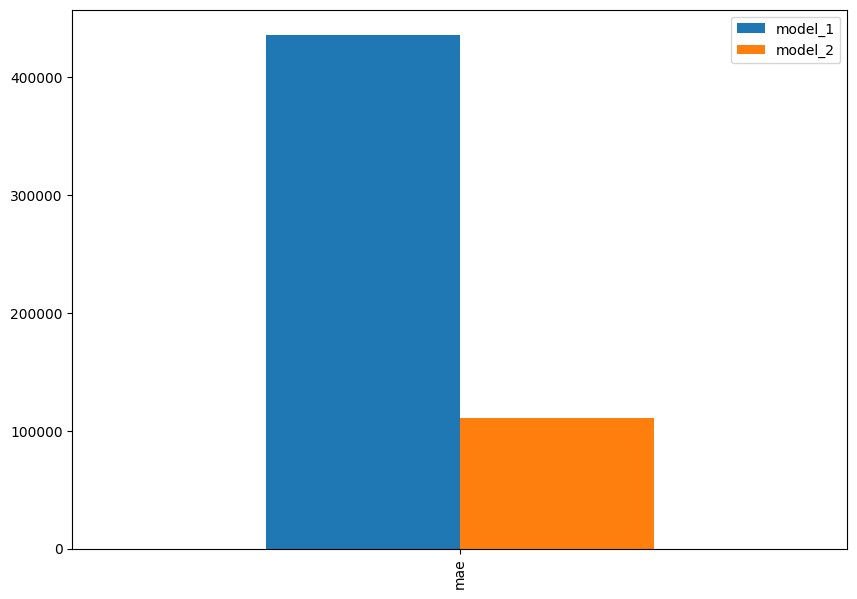

In [34]:
pd.DataFrame({
              "model_1": model_1_results["mae"],
              "model_2": model_2_results["mae"]
              }, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Compare to model1  , model_2 error is very low
######  As we were using LSTM in model_2

In [35]:
X_train.head()

,Volume,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2014-09-24,30627700.0,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-25,26814400.0,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-26,21460800.0,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-27,15029300.0,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-28,23613300.0,399.519989,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


### Creating Model in LSTM with window size 30 and normailzing data  and Volume Feature Here


In [36]:
# train_data.shape,test_data.shape

In [37]:
# train_data[2]

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame with the provided data
# Selecting relevant columns
data = btc_data_modified[['price']].values

# Normalizing the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the sequence length (number of time steps to consider)
seq_length = 30

# Creating sequences of data
X = []
y = []
for i in range(len(scaled_data) - seq_length):
    X.append(scaled_data[i:i+seq_length])  # Sequence of historical data
    y.append(scaled_data[i+seq_length, 0])  # Next day's price

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape X to match the input shape of LSTM (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # 2 features: Price and Volume


In [39]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [40]:
(len(X_train)),len(X_test)

(2771, 693)

Epoch 1/10
87/87 [==============================] - 14s 122ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 2/10
87/87 [==============================] - 9s 101ms/step - loss: 7.2254e-04 - val_loss: 0.0010
Epoch 3/10
87/87 [==============================] - 2s 29ms/step - loss: 6.4419e-04 - val_loss: 0.0012
Epoch 4/10
87/87 [==============================] - 10s 111ms/step - loss: 5.3998e-04 - val_loss: 6.8519e-04
Epoch 5/10
87/87 [==============================] - 2s 29ms/step - loss: 5.9912e-04 - val_loss: 7.4046e-04
Epoch 6/10
87/87 [==============================] - 3s 29ms/step - loss: 4.5616e-04 - val_loss: 0.0016
Epoch 7/10
87/87 [==============================] - 9s 101ms/step - loss: 4.6162e-04 - val_loss: 4.9054e-04
Epoch 8/10
87/87 [==============================] - 3s 29ms/step - loss: 3.8466e-04 - val_loss: 4.9958e-04
Epoch 9/10
87/87 [==============================] - 3s 29ms/step - loss: 3.1346e-04 - val_loss: 4.9116e-04
Epoch 10/10
87/87 [==============================] 

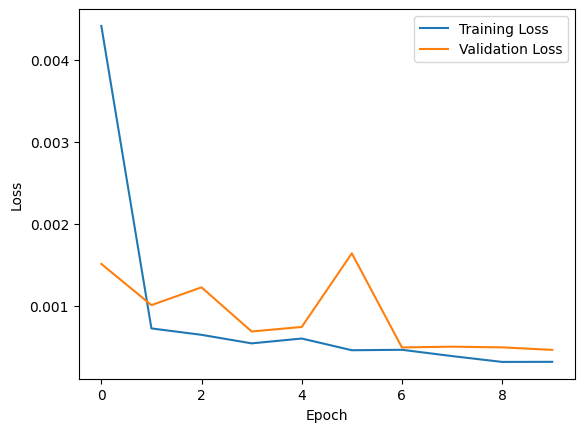

In [41]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



model_3 = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(30, 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)
],name="model_3")

# Compile the model
model_3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
                      callbacks=[create_model_checkpoint(model_name=model_3.name)])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions


22/22 [==============================] - 1s 11ms/step


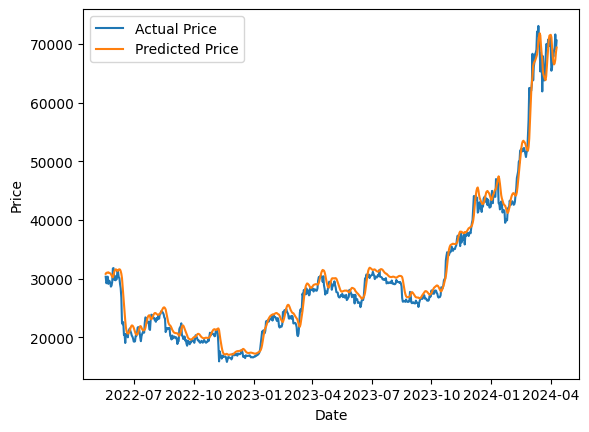

In [42]:

# predictions = model.predict(X_test)
predictions = make_preds(model_3, X_test)
predictions = scaler.inverse_transform(tf.expand_dims(predictions,axis=1))

# Plot actual vs. predicted prices

plt.plot(btc_data_modified.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label='Actual Price')
plt.plot(btc_data_modified.index[-len(y_test):], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
# model.summary()

### By Visualizing

Our Predicited Line is lagging behind the Predicted Line

In [43]:
model_3_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=tf.squeeze(predictions))
model_3_results

{'mae': 30746.857, 'mse': 1100057200.0, 'rmse': 33167.11, 'mape': 7553718.0}

#### Comparing the all Models Errors

{'model_1': 435117.03, 'model_2': 110632.12, 'model_3': 30746.857}


<Axes: >

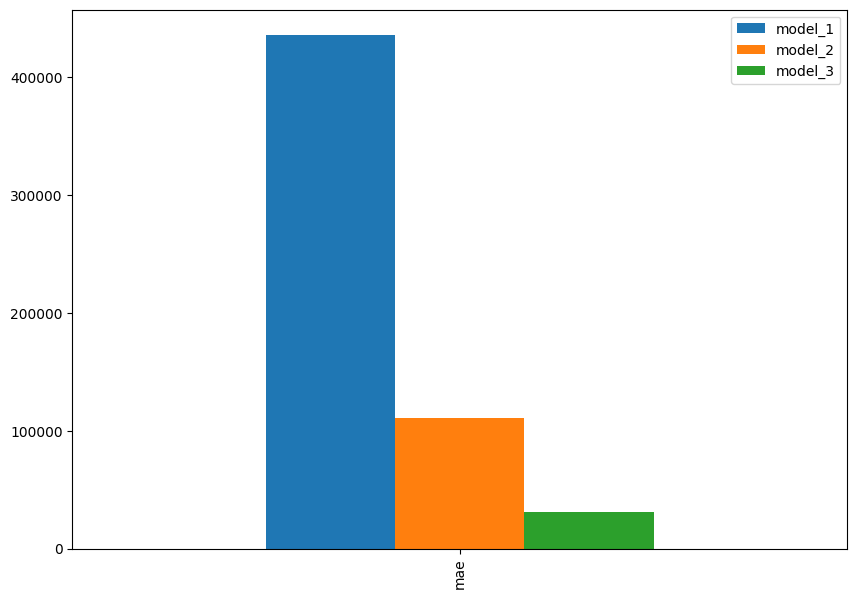

In [44]:
models_results_list = [model_1_results, model_2_results,model_3_results]

def compare_models_results(models_results_list,error_name):
   model_values = {}
   for i in range(1,len(models_results_list)+1):
      key_name = f"model_{i}"
      value_name = models_results_list[i-1][error_name]


      model_values[key_name] = value_name

   print(model_values)

   return pd.DataFrame(model_values,index=["mae"]).plot(figsize=(10, 7), kind="bar");

compare_models_results(models_results_list,"mae")




#### Now We are trying add One More Feature

### Creating Dataset for LSTM

#### with Volume and Price Feature


Epoch 1/100
88/88 [==============================] - 11s 88ms/step - loss: 0.0162 - val_loss: 0.0027
Epoch 2/100
88/88 [==============================] - 8s 88ms/step - loss: 6.8217e-04 - val_loss: 0.0013
Epoch 3/100
88/88 [==============================] - 7s 78ms/step - loss: 5.2880e-04 - val_loss: 0.0010
Epoch 4/100
88/88 [==============================] - 8s 89ms/step - loss: 4.5871e-04 - val_loss: 5.5455e-04
Epoch 5/100
88/88 [==============================] - 7s 78ms/step - loss: 4.0837e-04 - val_loss: 5.4817e-04
Epoch 6/100
88/88 [==============================] - 8s 90ms/step - loss: 4.1112e-04 - val_loss: 5.3079e-04
Epoch 7/100
88/88 [==============================] - 7s 79ms/step - loss: 3.5343e-04 - val_loss: 5.2650e-04
Epoch 8/100
88/88 [==============================] - 7s 78ms/step - loss: 3.1946e-04 - val_loss: 4.3861e-04
Epoch 9/100
88/88 [==============================] - 1s 6ms/step - loss: 2.9723e-04 - val_loss: 6.5793e-04
Epoch 10/100
88/88 [========================

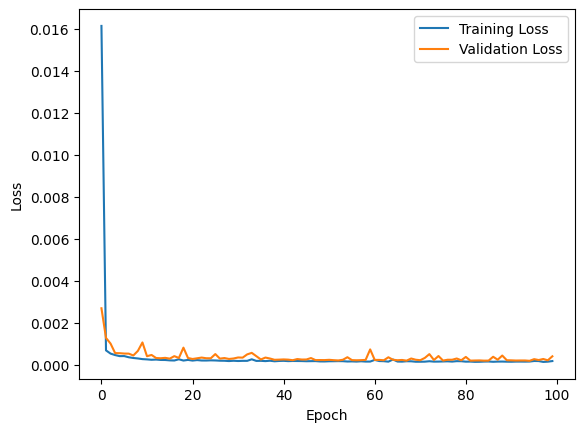

In [45]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

price_data = btc_data_modified['price'].values
volume_data = btc_data_modified['Volume'].values

# Reshape data to make it compatible with LSTM input shape (samples, timesteps, features)
# Here, we'll use historical prices and volumes as input features
seq_length = 10  # Number of historical data points to consider
X_price, X_volume, y = [], [], []
for i in range(len(price_data) - seq_length):
    X_price.append(price_data[i:i+seq_length])    # Sequence of historical prices
    X_volume.append(volume_data[i:i+seq_length])  # Sequence of historical volumes
    y.append(price_data[i+seq_length])            # Next day's price (target)

X_price = np.array(X_price)
X_volume = np.array(X_volume)
y = np.array(y)

# Reshape input data to match LSTM input shape (samples, timesteps, features)
X_price = np.reshape(X_price, (-1, X_price.shape[-1]))  # Flatten timesteps dimension
X_volume = np.reshape(X_volume, (-1, X_volume.shape[-1]))  # Flatten timesteps dimension

# Normalize data using MinMaxScaler
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
X_price_scaled = scaler_price.fit_transform(X_price)
X_volume_scaled = scaler_volume.fit_transform(X_volume)
y_scaled = scaler_price.fit_transform(y.reshape(-1, 1))  # Reshape y to 2D array for scaling

# Reshape input data back to original shape
X_price_scaled = np.reshape(X_price_scaled, (X_price.shape[0], -1, X_price.shape[-1]))
X_volume_scaled = np.reshape(X_volume_scaled, (X_volume.shape[0], -1, X_volume.shape[-1]))

# Concatenate price and volume features
X = np.concatenate((X_price_scaled, X_volume_scaled), axis=-1)

# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Build the LSTM model
model_4 = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=False),
    Dense(units=1)  # Output layer with 1 neuron for predicting the next day's price
],name="model_4")

# Compile the model
model_4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_4.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name= model_4.name)])

# Evaluate the model on test data



plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

22/22 [==============================] - 1s 3ms/step


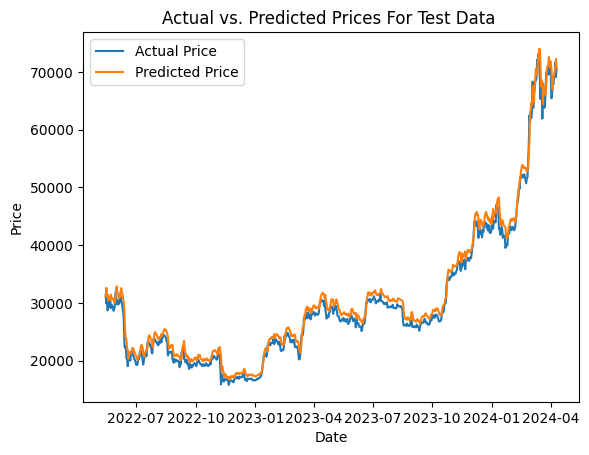

In [46]:
# predictions = model.predict(X_train)

predictions = make_preds(model_4, X_test)
predictions = scaler.inverse_transform(tf.expand_dims(predictions,axis=1))
# Inverse transform predictions to original scale
# predictions = scaler_price.inverse_transform(predictions)

# Plot actual vs. predicted prices
import matplotlib.pyplot as plt
plt.plot(btc_data_modified.index[-len(y_test):], scaler_price.inverse_transform(y_test), label='Actual Price')
plt.plot(btc_data_modified.index[-len(y_test):], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices For Test Data ')
plt.legend()
plt.show()

#### By adding Volume with Price The Actual and Predicted Line is Almost coincided

In [47]:
# model_4_results

{'model_1': 435117.03, 'model_2': 110632.12, 'model_3': 30746.857, 'model_4': 31130.795}


<Axes: >

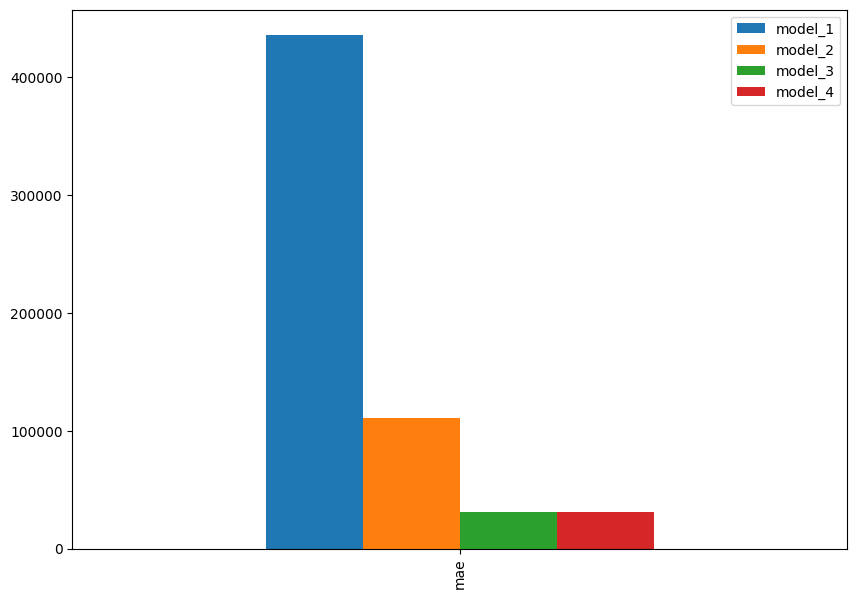

In [48]:
model_4_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=tf.squeeze(predictions))

models_results_list = [model_1_results,model_2_results,model_3_results,model_4_results]
# models_results_list.append(model_4_results)
compare_models_results(models_results_list,error_name="mae")

In [49]:
len(models_results_list)

4

In [50]:
### Writing a Function for Getting How Much Error in Prediction



In [55]:
def get_prediction(date, model, bitcoin_data, seq_length=10):
    # Convert date to datetime object
    date = pd.to_datetime(date)

    # Get the index of the date in the data
    index = bitcoin_data.index.get_loc(date)

    # Extract the last 'seq_length' days of data
    last_days_data = bitcoin_data.iloc[index-seq_length:index]

    # Extract the price and volume data
    price_data = np.array(last_days_data['price'].values).reshape(-1, 1)
    volume_data = np.array(last_days_data['Volume'].values).reshape(-1, 1)



    scaler_price = MinMaxScaler(feature_range=(0, 1))
    scaler_volume = MinMaxScaler(feature_range=(0, 1))
    price_scaled = scaler_price.fit_transform(price_data)
    volume_scaled = scaler_volume.fit_transform(volume_data)


    X_price_scaled = np.reshape(price_scaled, (1, price_data.shape[1],price_data.shape[0]))
    X_volume_scaled = np.reshape(volume_scaled, ( 1, volume_data.shape[1],volume_data.shape[0]))


    X = np.concatenate((X_price_scaled, X_volume_scaled), axis=2)







    prediction = model.predict(X)


    prediction = scaler_price.inverse_transform(prediction)


    next_day_price = prediction[0][0]
    return next_day_price, bitcoin_data.iloc[index]["price"]

In [71]:
btc_data_modified.tail()

,price,Volume
Date,,
2024-04-06,68896.109375,19967785809
2024-04-07,69362.554688,21204930369
2024-04-08,71631.359375,37261432669
2024-04-09,69139.015625,36426900409
2024-04-10,70587.882812,38318601774


In [100]:

def day_back():
  today = datetime.date.today()
  date = today - datetime.timedelta(days=2)
  return date

def data_download(ticker,start,end):
  data = yf.download(ticker,start,end)
  return data


def day_back_past():
  today = datetime.date.today()
  date = today - datetime.timedelta(days=3)
  return date


def get_predict_future(date, model, bitcoin_data, seq_length=10):

  # Convert date to datetime object
  date = pd.to_datetime(date)

  date_past = pd.to_datetime(day_back_past())

  # Get the index of the date in the data
  index = bitcoin_data.index.get_loc(date)

  past_index =  bitcoin_data.index.get_loc(date_past)

  last_days_past = bitcoin_data.iloc[past_index-seq_length:past_index]

  # Extract the last 'seq_length' days of data
  last_days_data = bitcoin_data.iloc[index-seq_length:index]

  # Extract the price and volume data
  price_data = np.array(last_days_data['price'].values).reshape(-1, 1)
  volume_data = np.array(last_days_data['Volume'].values).reshape(-1, 1)

  price_data_past = np.array(last_days_past['price'].values).reshape(-1, 1)
  volume_data_past = np.array(last_days_past['Volume'].values).reshape(-1, 1)




  scaler_price = MinMaxScaler(feature_range=(0, 1))
  scaler_volume = MinMaxScaler(feature_range=(0, 1))
  price_scaled = scaler_price.fit_transform(price_data)
  volume_scaled = scaler_volume.fit_transform(volume_data)

  price_scaled_past = scaler_price.fit_transform(price_data_past)
  volume_scaled_past = scaler_volume.fit_transform(volume_data_past)





  X_price_scaled = np.reshape(price_scaled, (1, price_data.shape[1],price_data.shape[0]))
  X_volume_scaled = np.reshape(volume_scaled, ( 1, volume_data.shape[1],volume_data.shape[0]))

  X_price_scaled_past = np.reshape(price_scaled_past, (1, price_data_past.shape[1],price_data_past.shape[0]))
  X_volume_scaled_past = np.reshape(volume_scaled_past, ( 1, volume_data_past.shape[1],volume_data_past.shape[0]))


  X = np.concatenate((X_price_scaled, X_volume_scaled), axis=2)
  X_past = np.concatenate((X_price_scaled_past, X_volume_scaled_past), axis=2)








  prediction = model.predict(X)
  prediction_past = model.predict(X_past)


  prediction = scaler_price.inverse_transform(prediction)

  prediction_past = scaler_price.inverse_transform(prediction_past)

  next_day_price = prediction[0][0]
  next_day_price_past = prediction_past[0][0]

  return next_day_price,next_day_price_past, bitcoin_data.iloc[index]["price"], bitcoin_data.iloc[index-1]["price"]



In [101]:
day_back()

datetime.date(2024, 4, 10)

In [107]:


predicition_of_future_day,prediction_of_past_day,actual_price,actual_past_price = get_predict_future(day_back(), model_4, btc_data_modified, seq_length=10)

print(f"Predicted Price: {predicition_of_future_day} Actual Price {actual_price}")

print(f"Predicted Past Price: {prediction_of_past_day}  Actual Past day price:{actual_past_price}")

print(f"Difference whether price goes up or not : {predicition_of_future_day-actual_past_price}")
print(f"Difference whether price goes up or not : {actual_price-actual_past_price}")


1/1 [==============================] - 0s 27ms/step
Predicted Price: 69947.7421875 Actual Price 70587.8828125
Predicted Past Price: 71418.8984375  Actual Past day price:69139.015625
Difference whether price goes up or not : 808.7265625
Difference whether price goes up or not : 1448.8671875


In [57]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             14200     
                                                                 
 lstm_4 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34451 (134.57 KB)
Trainable params: 34451 (134.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Trying Large Models for Time Series of LSTM


Epoch 1/100
87/87 [==============================] - 12s 100ms/step - loss: 0.0099 - val_loss: 0.0026
Epoch 2/100
87/87 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0027
Epoch 3/100
87/87 [==============================] - 7s 80ms/step - loss: 9.8091e-04 - val_loss: 0.0017
Epoch 4/100
87/87 [==============================] - 8s 95ms/step - loss: 7.4126e-04 - val_loss: 8.4868e-04
Epoch 5/100
87/87 [==============================] - 7s 83ms/step - loss: 6.1991e-04 - val_loss: 7.7723e-04
Epoch 6/100
87/87 [==============================] - 1s 8ms/step - loss: 4.4253e-04 - val_loss: 0.0010
Epoch 7/100
87/87 [==============================] - 7s 82ms/step - loss: 4.2980e-04 - val_loss: 5.0320e-04
Epoch 8/100
87/87 [==============================] - 1s 7ms/step - loss: 3.9951e-04 - val_loss: 5.2930e-04
Epoch 9/100
87/87 [==============================] - 1s 7ms/step - loss: 3.3581e-04 - val_loss: 5.3425e-04
Epoch 10/100
87/87 [==============================] - 

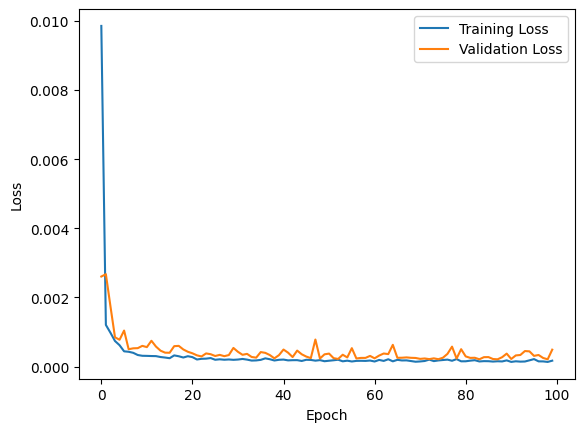

In [58]:

price_data = btc_data_modified['price'].values
volume_data = btc_data_modified['Volume'].values

# Reshape data to make it compatible with LSTM input shape (samples, timesteps, features)
# Here, we'll use historical prices and volumes as input features
seq_length = 30  # Number of historical data points to consider
X_price, X_volume, y = [], [], []
for i in range(len(price_data) - seq_length):
    X_price.append(price_data[i:i+seq_length])    # Sequence of historical prices
    X_volume.append(volume_data[i:i+seq_length])  # Sequence of historical volumes
    y.append(price_data[i+seq_length])            # Next day's price (target)

X_price = np.array(X_price)
X_volume = np.array(X_volume)
y = np.array(y)

# Reshape input data to match LSTM input shape (samples, timesteps, features)
X_price = np.reshape(X_price, (-1, X_price.shape[-1]))  # Flatten timesteps dimension
X_volume = np.reshape(X_volume, (-1, X_volume.shape[-1]))  # Flatten timesteps dimension

# Normalize data using MinMaxScaler
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
X_price_scaled = scaler_price.fit_transform(X_price)
X_volume_scaled = scaler_volume.fit_transform(X_volume)
y_scaled = scaler_price.fit_transform(y.reshape(-1, 1))  # Reshape y to 2D array for scaling

# Reshape input data back to original shape
X_price_scaled = np.reshape(X_price_scaled, (X_price.shape[0], -1, X_price.shape[-1]))
X_volume_scaled = np.reshape(X_volume_scaled, (X_volume.shape[0], -1, X_volume.shape[-1]))

# Concatenate price and volume features
X = np.concatenate((X_price_scaled, X_volume_scaled), axis=-1)

# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y_scaled[:split_index], y_scaled[split_index:]

# Build the LSTM model
model_5 =  Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(units=50, return_sequences=True),

    Dense(units=1)
],name="model_5")

# Compile the model
model_5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model_5.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1,validation_data=(X_test, y_test),callbacks=[create_model_checkpoint(model_name= model_5.name)])

# Evaluate the model on test data



plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


22/22 [==============================] - 1s 3ms/step


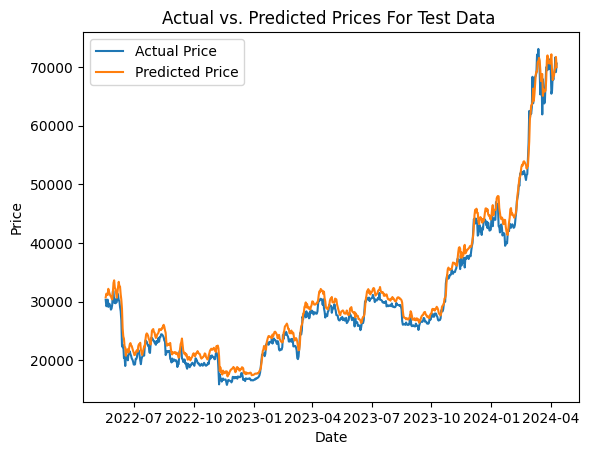

In [59]:
predictions = make_preds(model_5, X_test)


predictions = scaler_price.inverse_transform(tf.expand_dims(predictions,axis=1))
# Inverse transform predictions to original scale
# predictions = scaler_price.inverse_transform(predictions)

# Plot actual vs. predicted prices
import matplotlib.pyplot as plt
plt.plot(btc_data_modified.index[-len(y_test):], scaler_price.inverse_transform(y_test), label='Actual Price')
plt.plot(btc_data_modified.index[-len(y_test):], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices For Test Data ')
plt.legend()
plt.show()

In [60]:
len(X_test),len(y_test),y_test.shape

(693, 693, (693, 1))

In [61]:
len(predictions),predictions.shape

(693, (693, 1))

{'model_1_dense_multivariate': 435117.03, 'model_2_lstm': 110632.12, 'model_3': 30746.857, 'model_4': 31130.795}


<Axes: >

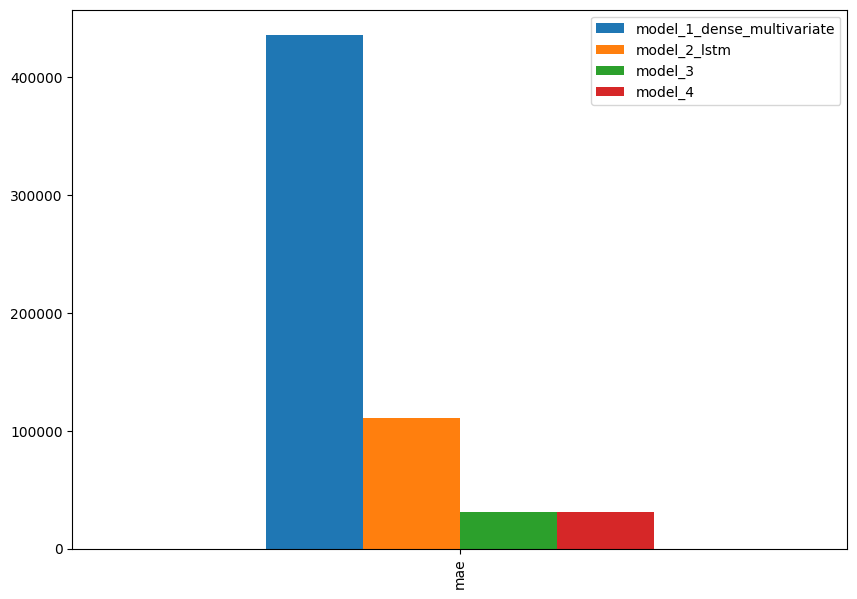

In [63]:

models_results_list = {

                       model_1.name:model_1_results,
                       model_2.name:model_2_results,
                       model_3.name:model_3_results,
                       model_4.name:model_4_results,
                      #  model_5.name:model_5_results
}


def compare_models_results(models_results_list,error_name):
   model_values = {}
   for i in models_results_list.keys():

      value_name = models_results_list[i][error_name]


      model_values[i] = value_name

   print(model_values)

   return pd.DataFrame(model_values,index=["mae"]).plot(figsize=(10, 7), kind="bar");

compare_models_results(models_results_list,"mae")

In [64]:
len(y_test),len(predictions)

model_5_results = evaluate_preds(y_true=tf.squeeze(y_test),
                                 y_pred=tf.squeeze(predictions))


models_results_list[model_5.name] = model_5_results


{'model_3': {'mae': 30746.857, 'mse': 1100057200.0, 'rmse': 33167.11, 'mape': 7553718.0}, 'model_4': {'mae': 31130.795, 'mse': 1131567100.0, 'rmse': 33638.773, 'mape': 7631612.5}, 'model_5': {'mae': 31288.34, 'mse': 1136927200.0, 'rmse': 33718.35, 'mape': 7693612.5}}
{'model_3': 30746.857, 'model_4': 31130.795, 'model_5': 31288.34}


<Axes: >

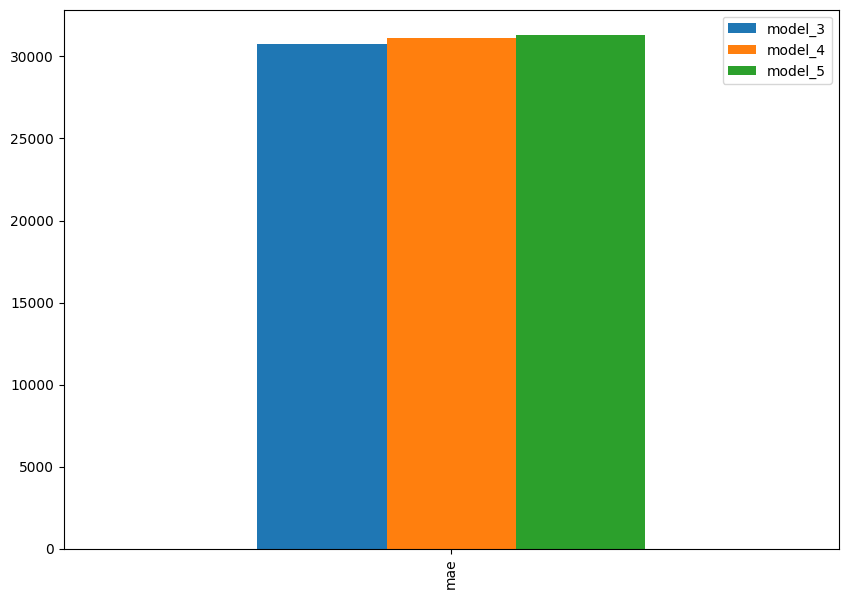

In [65]:
def custom_results_compare(models_name,error_name):
  models_dict = {}
  for i  in models_name:
    models_dict[i] = models_results_list[i]
  print(models_dict)
  return compare_models_results(models_dict,error_name)

custom_results_compare([model_3.name,model_4.name,model_5.name],error_name="mae")

In [66]:
models_results_list

{'model_1_dense_multivariate': {'mae': 435117.03,
  'mse': 247670520000.0,
  'rmse': 497665.06,
  'mape': 1637.8231},
 'model_2_lstm': {'mae': 110632.12,
  'mse': 14408894000.0,
  'rmse': 120037.055,
  'mape': 400.23557},
 'model_3': {'mae': 30746.857,
  'mse': 1100057200.0,
  'rmse': 33167.11,
  'mape': 7553718.0},
 'model_4': {'mae': 31130.795,
  'mse': 1131567100.0,
  'rmse': 33638.773,
  'mape': 7631612.5},
 'model_5': {'mae': 31288.34,
  'mse': 1136927200.0,
  'rmse': 33718.35,
  'mape': 7693612.5}}

In [67]:
X_test.shape

(693, 1, 60)

In [68]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 100)            64400     
                                                                 
 lstm_6 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dense_5 (Dense)             (None, 1, 1)              51        
                                                                 
Total params: 94651 (369.73 KB)
Trainable params: 94651 (369.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
